# Analysis of real results

In [1]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

# Set global figure style
plt.rcParams.update({
    "figure.figsize": (6, 4),  # Paper-friendly aspect ratio
    "figure.dpi": 300,  # High resolution for print
    "axes.titlesize": 12,  # Title font size
    "axes.labelsize": 10,  # Label font size
    "axes.linewidth": 1.2,  # Thicker axes for better readability
    "lines.linewidth": 2,  # Thicker plot lines
    "lines.markersize": 6,  # Default marker size
    "xtick.labelsize": 9,  # X-axis tick labels
    "ytick.labelsize": 9,  # Y-axis tick labels
    "xtick.direction": "in",  # Ticks pointing inward
    "ytick.direction": "in",
    "xtick.major.size": 5,  # Tick sizes
    "ytick.major.size": 5,
    "grid.linestyle": "--",  # Dashed grid lines
    "grid.alpha": 0.6,  # Slightly transparent grid
    "legend.fontsize": 9,  # Legend font size
    "legend.frameon": False,  # No legend box
    "savefig.bbox": "tight",  # Tight layout for saving
    "savefig.format": "pdf",  # Save as high-quality PDF
    "font.family": "serif",  # LaTeX-style serif font
})

FIGURE_PATH = r".\..\paper\figs"

def load_and_expand_telemetry(folder_path):
    all_data = []

    # Walk through all subfolders and files
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Only process files without an extension
            if not os.path.splitext(file)[1]:  
                with open(file_path, "r", encoding="utf-8") as f:
                    for line in f:
                        try:
                            json_obj = json.loads(line.strip())  # Load each line as a JSON object
                            
                            if "telemetry" in json_obj and isinstance(json_obj["telemetry"], dict):
                                # Expand telemetry fields
                                telemetry_data = json_obj.pop("telemetry")  # Remove telemetry field
                                expanded_record = {**json_obj, **telemetry_data}  # Merge dictionaries
                            else:
                                expanded_record = json_obj  # If no telemetry field, keep original

                            all_data.append(expanded_record)
                        except json.JSONDecodeError as e:
                            print(f"Skipping invalid JSON in {file_path}: {e}")

    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    return df

# Example usage
folder_path = r"C:\Users\NikolaiKummer\Documents\GIT\remote-data-collection\data\27cbf2b6-ab2f-49d6-9f05-fd938a9792b3"
df = load_and_expand_telemetry(folder_path)


In [2]:
keep_columns = ['deviceId','enqueuedTime', 'volt', 'bat', 'timestamp', 'last_state']
df = df[keep_columns]

In [3]:
start_date = pd.Timestamp('2024-10-05T01:27:16.842Z', tz='UTC')
end_date = pd.Timestamp('2024-10-14T19:41:21.170Z', tz='UTC')

def fill_missing_timestamps(df, column='timestamp'):
    """
    Fills missing values in a timestamp column with the average of the previous and next timestamp.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing a timestamp column.
    column (str): Name of the timestamp column. Default is 'timestamp'.
    
    Returns:
    pd.DataFrame: DataFrame with missing timestamps filled.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    df[column] = pd.to_datetime(df[column])  # Ensure timestamps are in datetime format

    # Identify missing values
    missing_idx = df[column].isna()
    df[column] = df[column].astype('int64')
    # Fill missing values with the midpoint of the previous and next timestamps
    df.loc[missing_idx, column] = (df[column].shift(1) + df[column].shift(-1)) / 2
    df[column] = pd.to_datetime(df[column])  # Convert back to datetime format
    return df


df['enqueuedTime'] = pd.to_datetime(df['enqueuedTime'])
df = df[(df['enqueuedTime'] >= start_date) & (df['enqueuedTime'] <= end_date)]

# Clean up timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.loc[df['timestamp'] < pd.Timestamp('2024-01-01', tz='UTC'), 'timestamp'] = pd.NaT
df = fill_missing_timestamps(df)

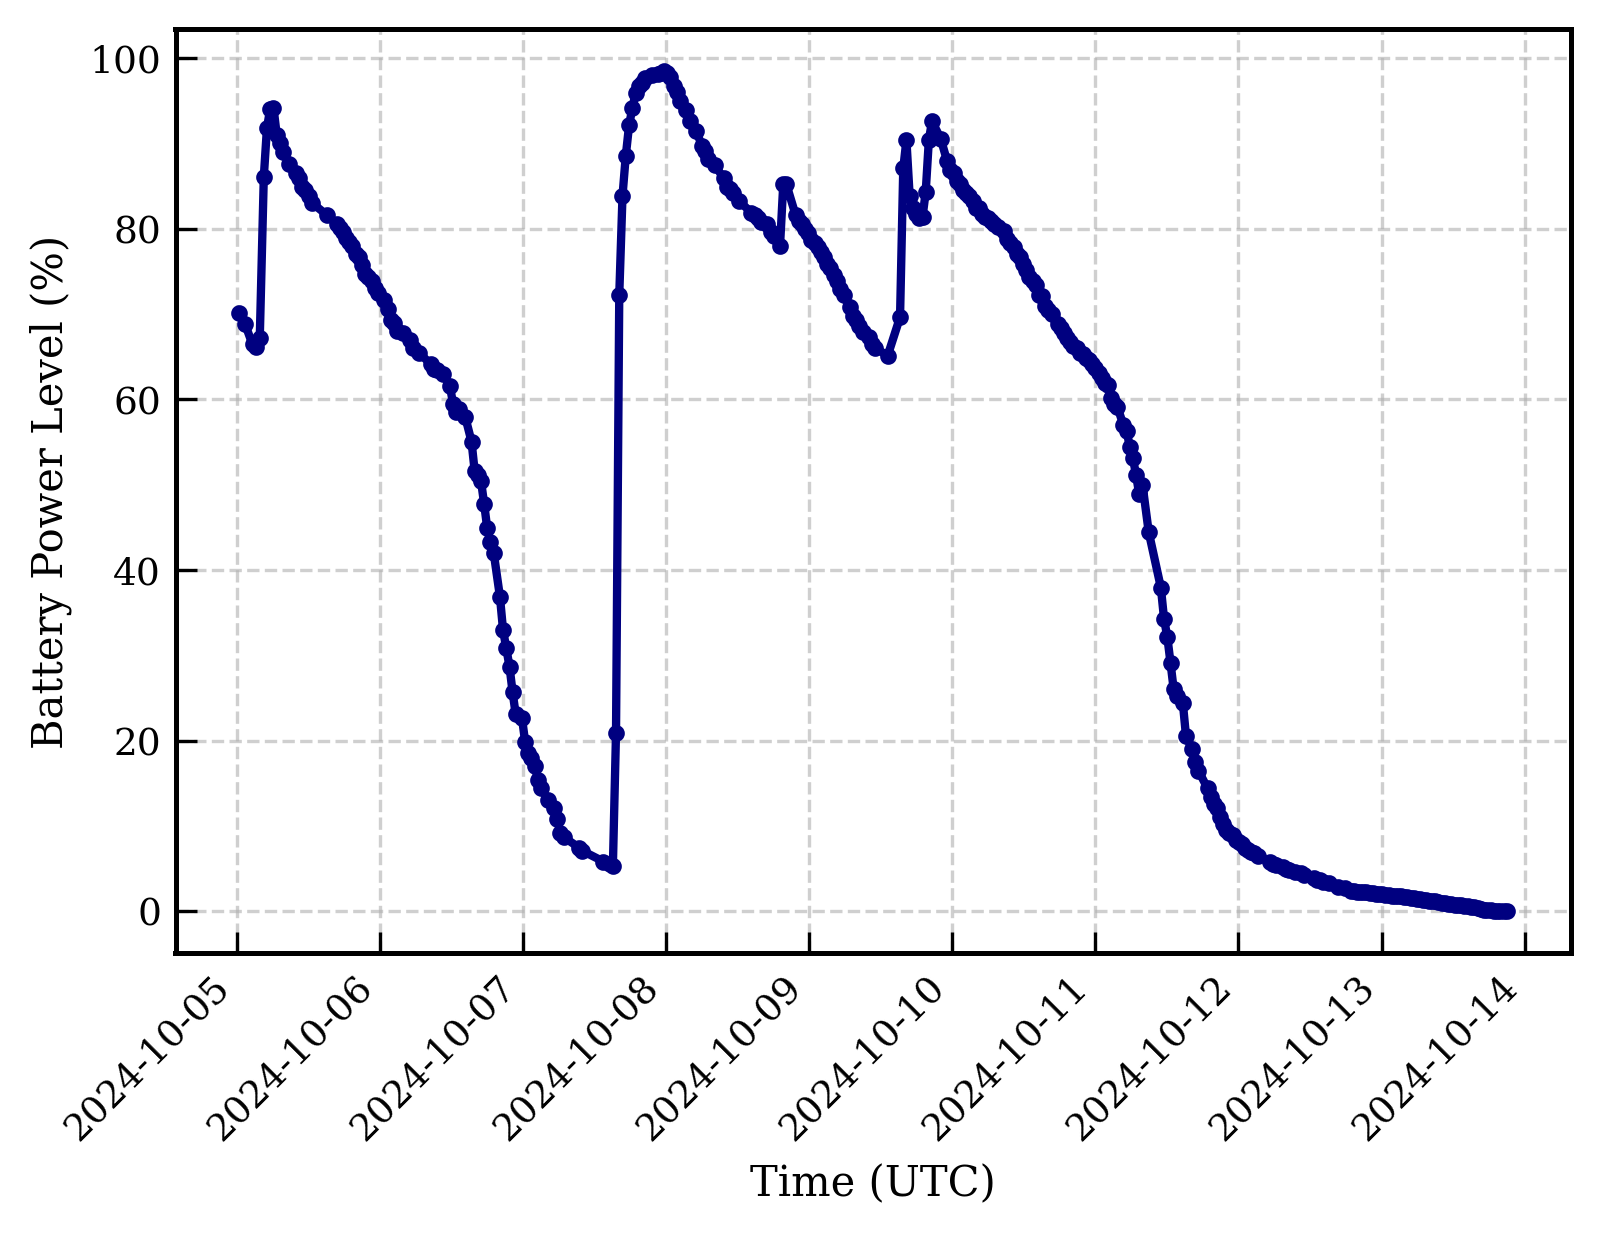

In [4]:
fig, ax = plt.subplots()
plt.plot(df['timestamp'], df['bat'], '.-', color='navy')

plt.ylabel('Battery Power Level (%)')
plt.xlabel('Time (UTC)')
# turn x-ticks 45 degrees
plt.xticks(rotation=45, ha='right')
plt.grid(True)

fig.savefig(os.path.join(FIGURE_PATH, 'prototype_power_level.png'), bbox_inches='tight')

In [5]:
# Create a difference in timestamp column
dft = df.copy()
dft['diff'] = dft['timestamp'].diff().dt.total_seconds()

print(f"Average time difference: {dft['diff'].mean()} seconds")
print(f"Median time difference: {dft['diff'].median()} seconds")

Average time difference: 2430.44126984127 seconds
Median time difference: 1929.0 seconds


# Ratio of Collection to Transmission

In [6]:
# round enqueueTime to nearest minute
dft['enqueuedTime'] = dft['enqueuedTime'].dt.round('min')

total_transmissions = dft['enqueuedTime'].nunique()
total_collections = dft['timestamp'].nunique()

print(f"Total number of unique enqueuedTime: {total_transmissions}")
print(f"Total number of unique timestamps: {total_collections}")
print(f"Ratio of unique timestamps to unique enqueuedTime: {total_collections / total_transmissions:.2f}")


Total number of unique enqueuedTime: 145
Total number of unique timestamps: 316
Ratio of unique timestamps to unique enqueuedTime: 2.18


C:\Users\NikolaiKummer\AppData\Local\Temp\ipykernel_30680\3391814638.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfk = dfs.groupby('bat_bin').agg({


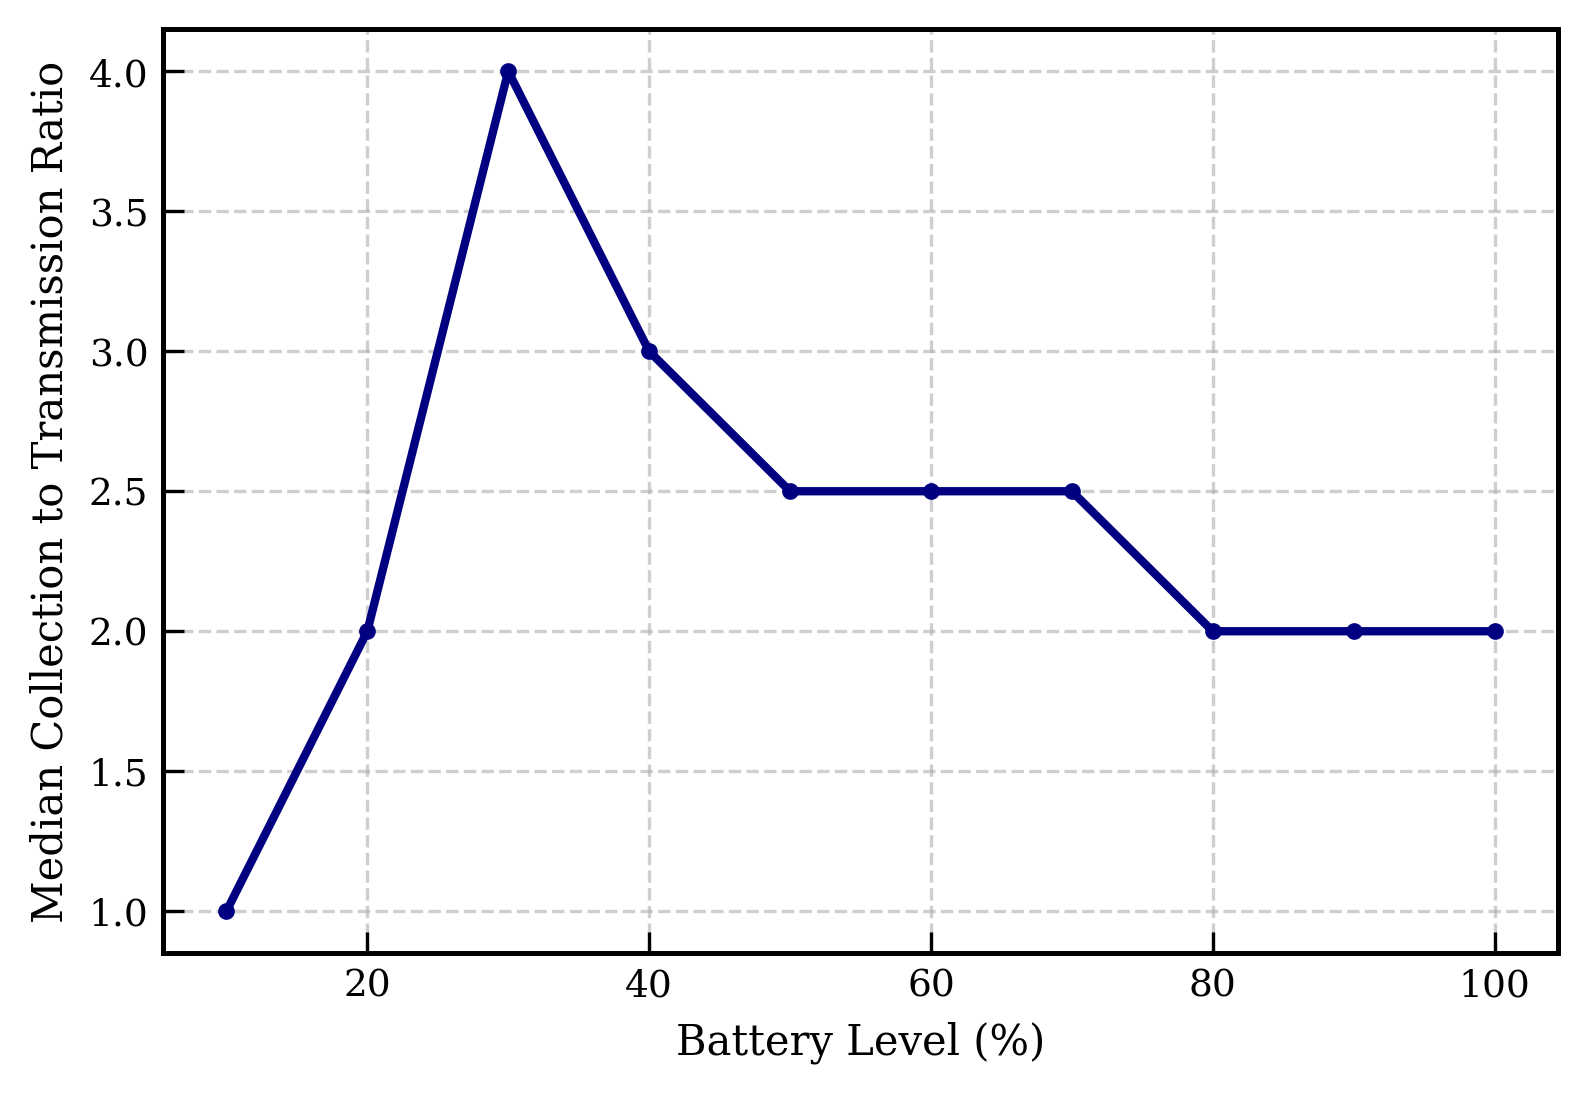

In [ ]:
dfs = dft.groupby('enqueuedTime').agg({
    'timestamp': 'nunique',
    'bat': 'mean'
}).reset_index()
dfs

# bin the bat value into 10% and get the mean of the timestamp
bins = range(0, 110, 10)
dfs['bat_bin'] = pd.cut(dfs['bat'], bins=bins, labels=bins[1:])
dfk = dfs.groupby('bat_bin').agg({
    'timestamp': 'median',
}).reset_index()
dfk

fig, ax = plt.subplots()
plt.plot(dfk['bat_bin'], dfk['timestamp'], '.-',color="navy")
plt.xlabel('Battery Level (%)')
plt.ylabel('Median Messages Per Transmission')
plt.grid(True)
# fig.savefig(r'.\..\paper\figs\battery_level_vs_collection_ratio.png', bbox_inches='tight')
fig.savefig(os.path.join(FIGURE_PATH, 'battery_level_vs_collection_ratio.png'), bbox_inches='tight')

# Determine the number of messages collected in total

In [22]:
experiment_start_time = dft['enqueuedTime'].min()
experiment_end_time = dft['enqueuedTime'].max()

print(f"Experiment start time: {experiment_start_time}")
print(f"Experiment end time: {experiment_end_time}")
print(f"Experiment duration: {experiment_end_time - experiment_start_time}")
print(f"Experiment duration in seconds: {(experiment_end_time - experiment_start_time).total_seconds():,}")

transmissions= dft['timestamp'].nunique()
print(f"Total Messages send during the experiment: {transmissions}")
median_transmission_interval = dft['diff'].median()
print(f"Median transmission interval: {median_transmission_interval} seconds")
print(f"Expected Messages send during the experiment: {((experiment_end_time - experiment_start_time).total_seconds() / median_transmission_interval):,.0f}")


Experiment start time: 2024-10-05 01:27:00+00:00
Experiment end time: 2024-10-13 21:04:00+00:00
Experiment duration: 8 days 19:37:00
Experiment duration in seconds: 761,820.0
Total Messages send during the experiment: 316
Median transmission interval: 1929.0 seconds
Expected Messages send during the experiment: 395


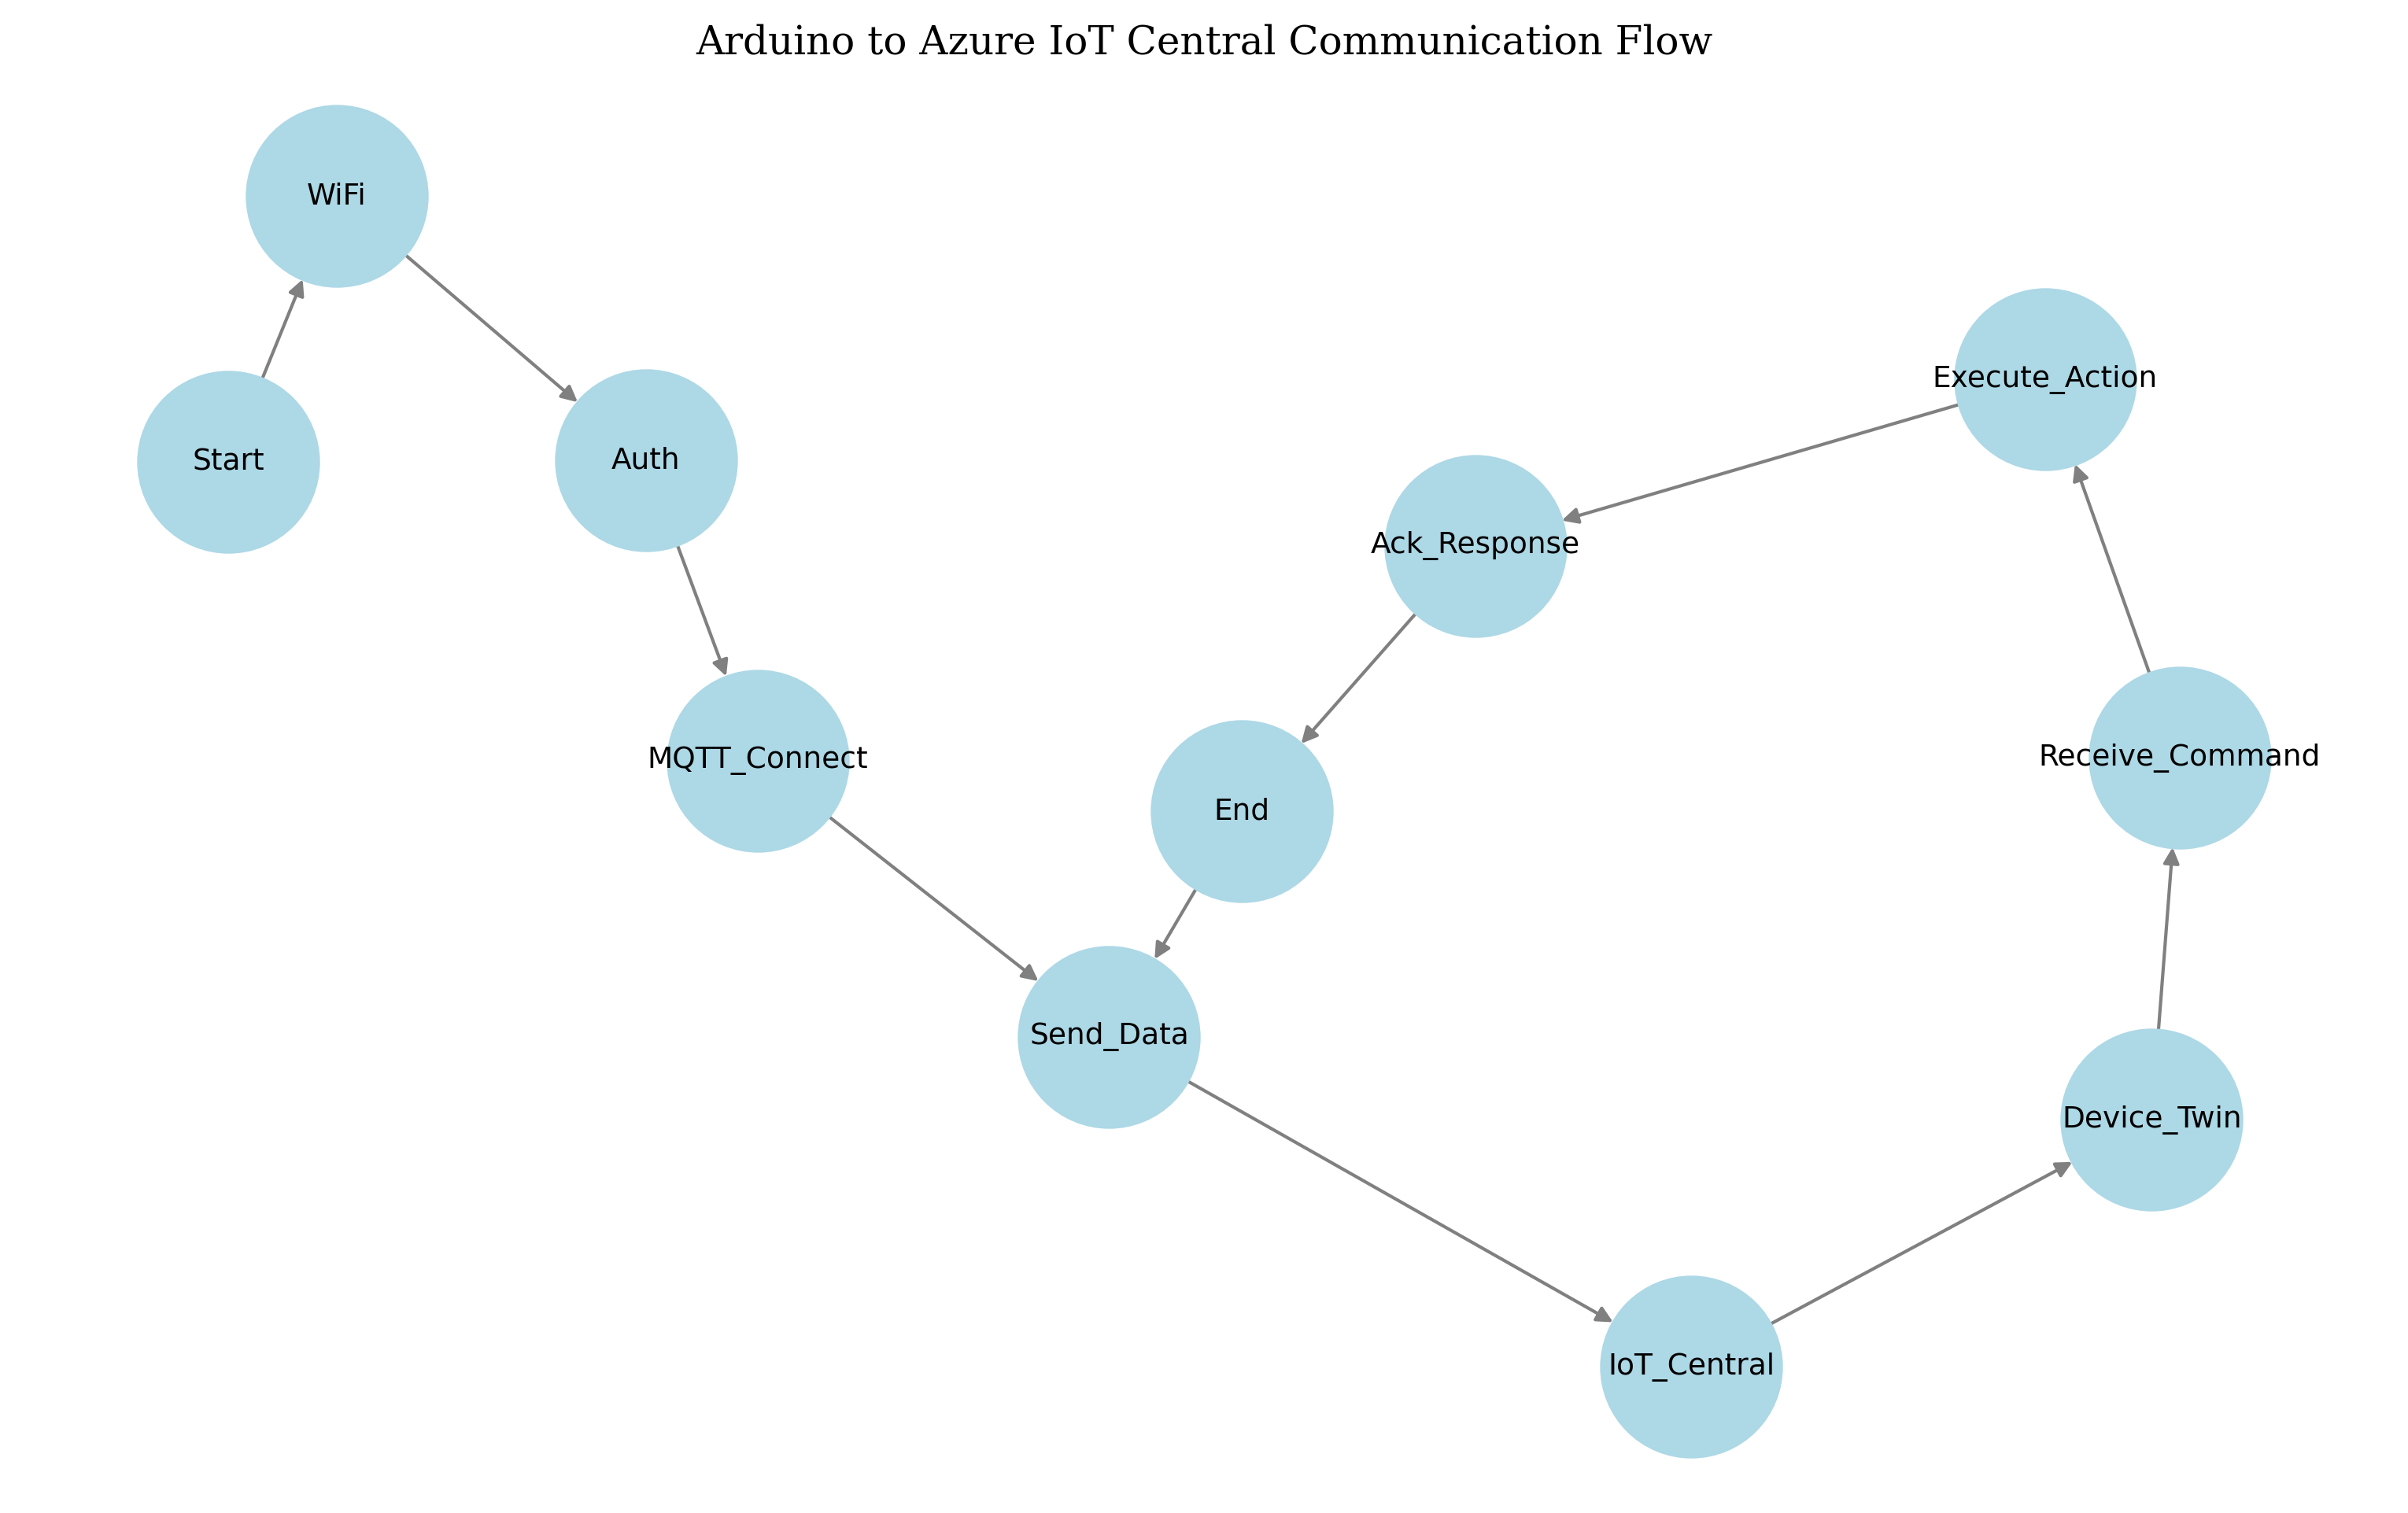

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define nodes
nodes = {
    "Start": "Device Startup",
    "WiFi": "Connect to WiFi",
    "Auth": "Authenticate with Azure IoT Hub (SAS/X.509)",
    "MQTT_Connect": "Establish MQTT Connection",
    "Send_Data": "Publish Telemetry Data to IoT Hub",
    "IoT_Central": "Azure IoT Central Processes Data",
    "Device_Twin": "Device Twin Sync (State Updates)",
    "Receive_Command": "Receive Command from IoT Central",
    "Execute_Action": "Execute Command on Device",
    "Ack_Response": "Send Acknowledgment or Response",
    "End": "Process Complete / Repeat"
}

# Add nodes to the graph
G.add_nodes_from(nodes.keys())

# Define edges (connections between steps)
edges = [
    ("Start", "WiFi"),
    ("WiFi", "Auth"),
    ("Auth", "MQTT_Connect"),
    ("MQTT_Connect", "Send_Data"),
    ("Send_Data", "IoT_Central"),
    ("IoT_Central", "Device_Twin"),
    ("Device_Twin", "Receive_Command"),
    ("Receive_Command", "Execute_Action"),
    ("Execute_Action", "Ack_Response"),
    ("Ack_Response", "End"),
    ("End", "Send_Data")  # Loop back for continuous operation
]

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # Layout for better spacing
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="gray", font_size=9)

# Display the flowchart
plt.title("Arduino to Azure IoT Central Communication Flow")
plt.show()

